Fitting 3 folds for each of 50 candidates, totalling 150 fits
정확도: 0.7700
정밀도: 0.7816
재현율: 0.7158
F1 스코어: 0.7473
ROC AUC: 0.8640
KS 값: 0.6010


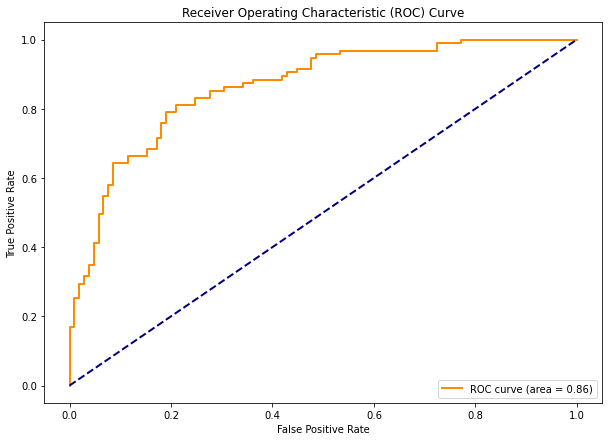

In [1]:
# 1. 필요한 라이브러리와 샘플 데이터 생성
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 평가 지표 계산 함수
def evaluate_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    ks = max(tpr - fpr)
    
    return accuracy, precision, recall, f1, roc_auc, ks

# 샘플 데이터 생성
np.random.seed(42)
X = np.random.rand(1000, 10)
y = (X[:, 0] + X[:, 1] + np.random.rand(1000) > 1.5).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. LGBM 모델 학습 및 하이퍼파라미터 튜닝
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [-1, 3, 4, 5, 6, 7, 8],
    'num_leaves': [31, 50, 70, 100],
    'min_child_samples': [10, 20, 30, 40]
}

clf = lgb.LGBMClassifier()
rand_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1, random_state=42)
rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 평가 지표 출력
accuracy, precision, recall, f1, roc_auc, ks = evaluate_model(y_test, y_pred, y_prob)
print(f"정확도: {accuracy:.4f}")
print(f"정밀도: {precision:.4f}")
print(f"재현율: {recall:.4f}")
print(f"F1 스코어: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"KS 값: {ks:.4f}")

# ROC_AUC 그래프 출력
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_area = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_area:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
